In [24]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [25]:
# Diretório onde as imagens estão localizadas
dataset_dir = 'dataset'

In [26]:
# Função para carregar e pré-processar as imagens
def load_data():
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    # Carregar os dados de treinamento e validação
    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(224, 224),  # Tamanho correto para ResNet50
        batch_size=32,
        class_mode='sparse',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse',
        subset='validation'
    )

    return train_generator, validation_generator

In [27]:
# Função para construir o modelo
def build_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Tamanho de entrada correto
    )
    base_model.trainable = False  # Congelar inicialmente

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),  # Camada para extração de features
        layers.Dense(4, activation='softmax')    # Camada de classificação
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [28]:
# Função para criar modelo de extração de características
def create_feature_extractor(trained_model):
    return models.Model(
        inputs=trained_model.input,
        outputs=trained_model.layers[-2].output  # Extrai a camada de 1024 neurônios
    )

In [29]:
# Função para extrair características
def extract_features(feature_model, image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Não foi possível ler a imagem: {image_path}")
        
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)  # Pré-processamento correto
    img = np.expand_dims(img, axis=0)
    
    features = feature_model.predict(img)
    return features.flatten()

In [30]:
# Função de recomendação
def recommend_image(feature_model, image_path, feature_array, knn):
    try:
        features = extract_features(feature_model, image_path)
        features = features.reshape(1, -1)
        features = normalize(features, norm='l2')  # Normalização adicional
        
        distances, indices = knn.kneighbors(features)
        return indices[0], distances[0]
    except Exception as e:
        print(f"Erro na recomendação: {str(e)}")
        return [], []

Found 64 images belonging to 4 classes.
Found 13 images belonging to 4 classes.
Treinando o modelo...
Epoch 1/15
2/2 [==============================] - 3s 790ms/step - loss: 1.2866 - accuracy: 0.5156 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/15
2/2 [==============================] - 0s 210ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.1181e-05 - val_accuracy: 1.0000
Epoch 3/15
2/2 [==============================] - 0s 212ms/step - loss: 8.7148e-05 - accuracy: 1.0000 - val_loss: 9.9489e-06 - val_accuracy: 1.0000
Epoch 4/15
2/2 [==============================] - 0s 210ms/step - loss: 7.9103e-04 - accuracy: 1.0000 - val_loss: 9.8022e-06 - val_accuracy: 1.0000
Epoch 5/15
2/2 [==============================] - 0s 210ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 6.9322e-06 - val_accuracy: 1.0000
Epoch 6/15
2/2 [==============================] - 0s 208ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.2089e-06 - val_accuracy: 1.0000
Epoch 7/15
2/2 [==============

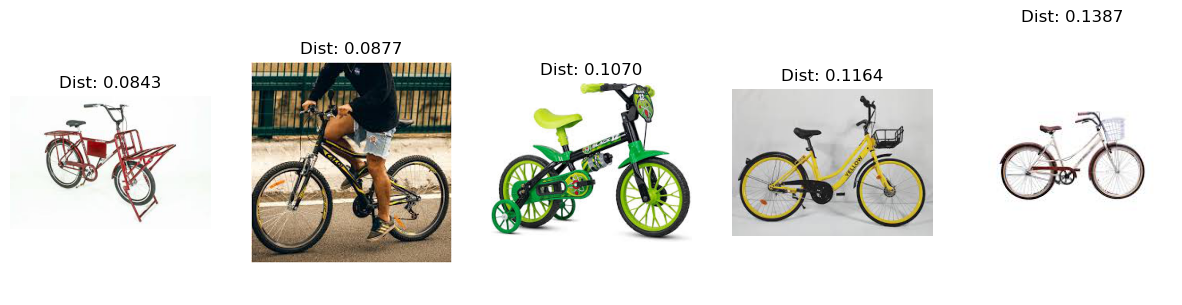

In [31]:
# Carregar dados
train_generator, validation_generator = load_data()

# Construir e treinar modelo
model = build_model()
print("Treinando o modelo...")
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15  # Reduzido para demonstração
)

# Criar modelo para extração de características
feature_model = create_feature_extractor(model)

# Coletar caminhos das imagens
all_image_paths = []
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths.append(os.path.join(root, file))

if not all_image_paths:
    print("Nenhuma imagem encontrada!")
else:
    # Extrair e normalizar características
    feature_list = [extract_features(feature_model, path) for path in all_image_paths]
    feature_array = normalize(np.array(feature_list), norm='l2')

    # Treinar KNN
    knn = NearestNeighbors(n_neighbors=5, metric='cosine')
    knn.fit(feature_array)

    # Testar recomendação
    test_image = 'images6.jpg'  # Substituir pela sua imagem
    indices, distances = recommend_image(feature_model, test_image, feature_array, knn)

    # Mostrar resultados
    print("Imagens recomendadas:")
    plt.figure(figsize=(15, 10))
    for i, (idx, dist) in enumerate(zip(indices, distances)):
        img = cv2.imread(all_image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img)
        plt.title(f"Dist: {dist:.4f}")
        plt.axis('off')
    
    plt.show()
